# MODEL: Predicting if there is a risk of stroke.

## Context

In a global context, stroke ranks as the second leading cause of death, contributing to around 11% of all fatalities, as reported by the World Health Organization (WHO). The dataset at hand is designed for forecasting the likelihood of a patient experiencing a stroke. It does so by analyzing input factors such as gender, age, the presence of different medical conditions, and smoking habits. Each row within the dataset furnishes essential details regarding the patient's health.

The dataset's Variables:          
1) id: unique identifier     
2) gender: "Male", "Female" or "Other"     
3) age: age of the patient     
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension          
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease     
6) ever_married: "No" or "Yes"            
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"          
8) Residence_type: "Rural" or "Urban"              
9) avg_glucose_level: average glucose level in blood               
10) bmi: body mass index       
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*           
12) stroke: 1 if the patient had a stroke or 0 if not       


*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

Source of dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

## O. Importing the libraries:

In [1]:
#!pip install keras-tuner

In [2]:
!pip install scikit-optimize

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE

# Metrics that would allow us to evaluate our model
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

#saving and exporting the model
from joblib import dump
import pickle
import joblib

## 1.Load the dataset



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Specify the file path
file_path = '/content/drive/Shareddrives/MBD Term2 - Group 6/ML_Group Project/healthcare-dataset-stroke-data.csv'

# Load the data into a DataFrame
data = pd.read_csv(file_path)

In [6]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
data.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## 2. Visualize Data:

### 2.1 Understanding the target variable:

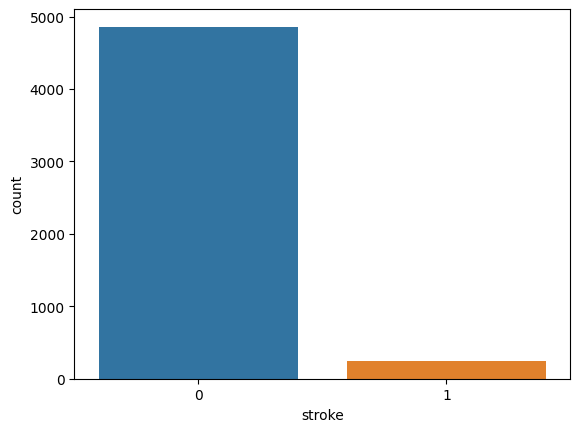

In [9]:
# Countplot to check class balance
sns.countplot(x='stroke', data=data)
plt.show()

From the distribution of the target variable we can see that the dataset is very unbalanced. Most of the dataset relates to patient that did not present a risk of stroke. As often in healthcare studies we observe more healthy clusters than unhealthy ones. Therefore, one important step will be to balance the training set in order to train properly the algorithm to identify both cases: Risk of Stroke, and No Risk of Stroke. This will be done in the 4th part when splitting the dataset into training and testing.

### 2.2: Looking into the categorical variables:

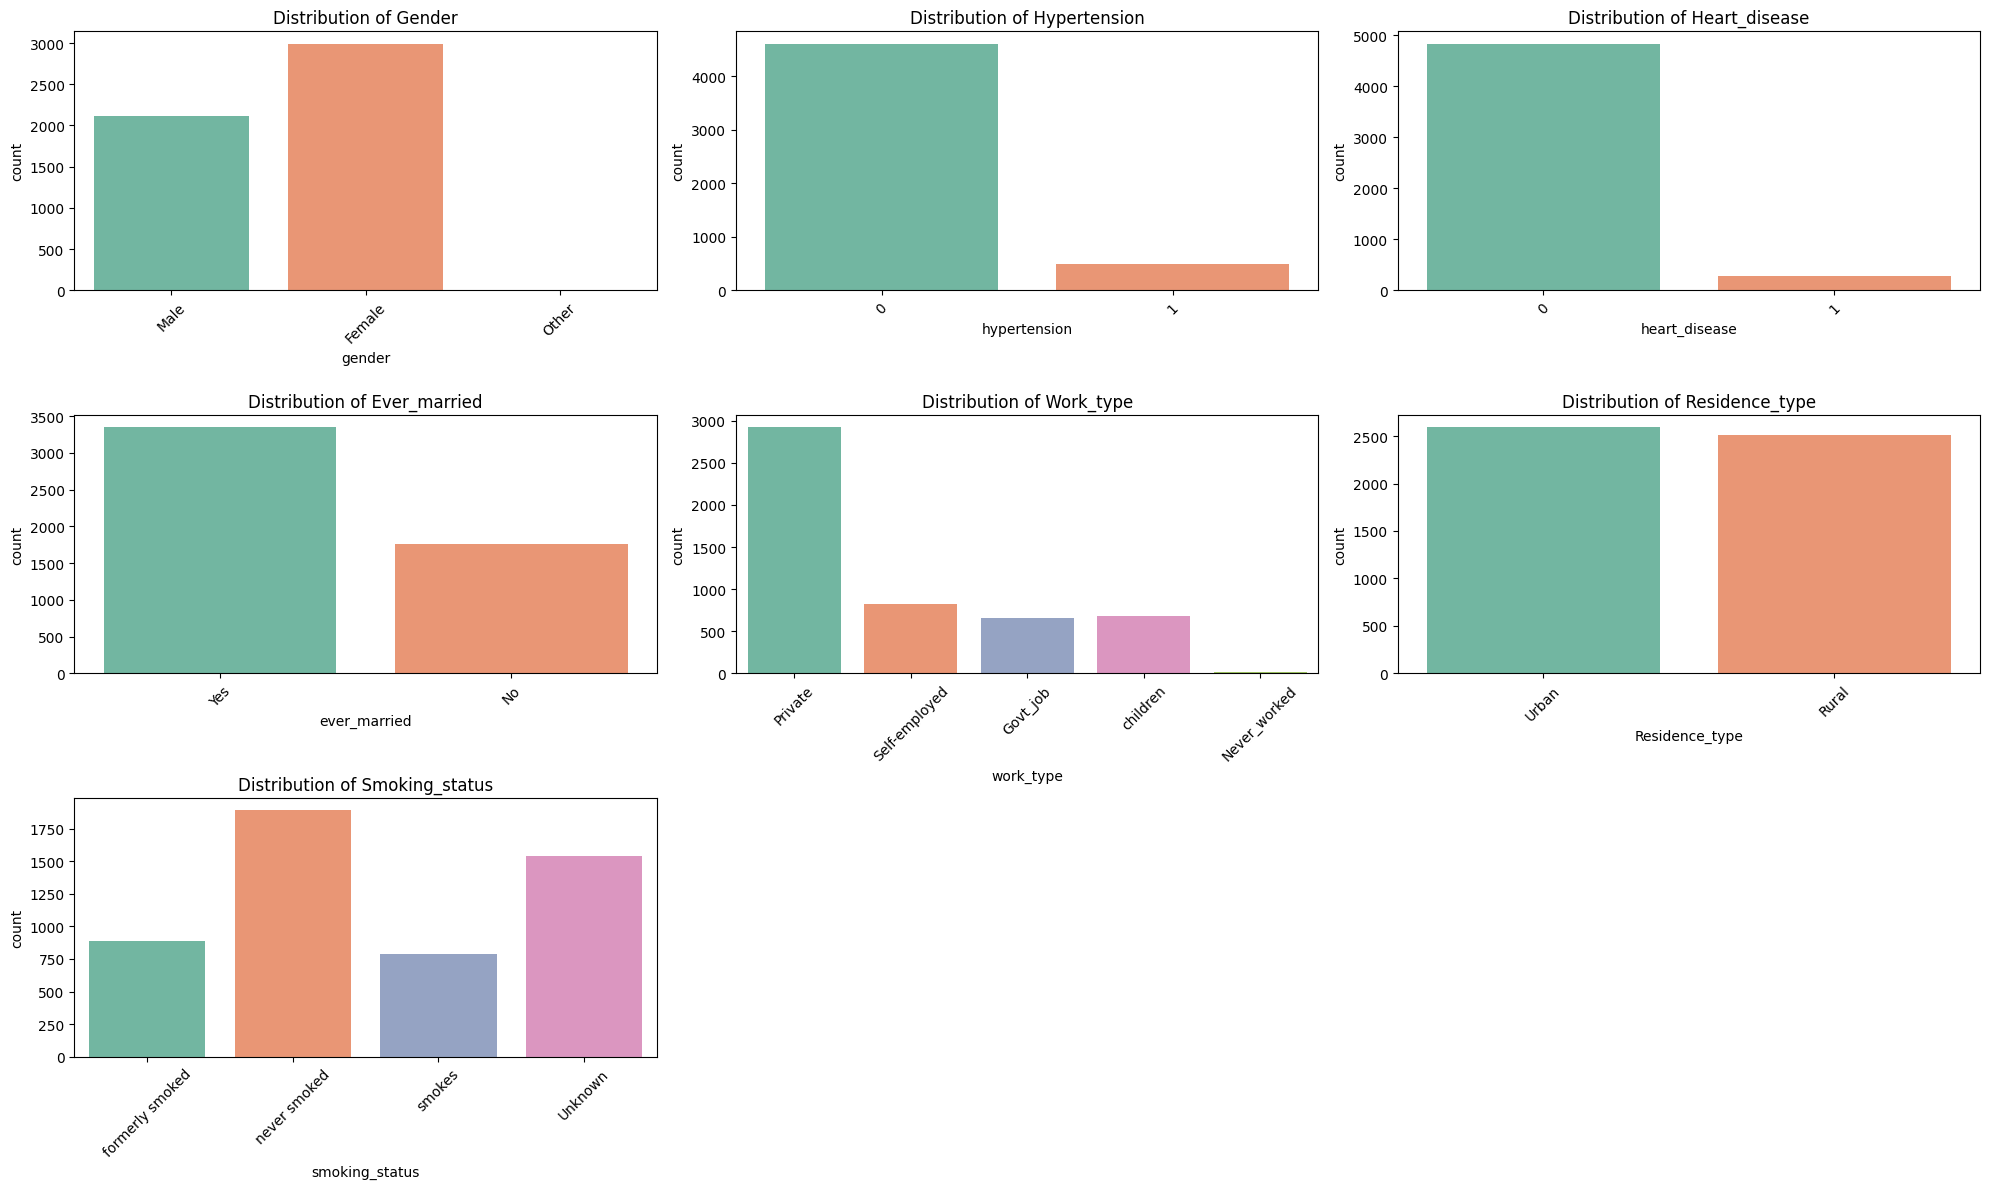

In [10]:
# Bar charts for categorical variables
categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

plt.figure(figsize=(20, 12))
for i, var in enumerate(categorical_vars):
    plt.subplot(3, 3, i+1)
    sns.countplot(x=var, data=data, palette="Set2")
    plt.title(f'Distribution of {var.capitalize()}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Let's analyse each variable one bye one:
- **Gender:** The dataset contains more female patients than male patients, with a very small number of 'Other' gender category. This imbalance should be considered during analysis and model training to avoid bias.
- **Hypertension:** A smaller proportion of patients have hypertension. This is consistent with general health statistics, but the impact of hypertension on stroke risk could be significant.
- **Heart Disease:** The number of patients with heart disease is relatively low, similar to hypertension, which may suggest that these conditions are relatively less common or underreported in the dataset.
- **Ever Married:** The majority of patients have been married, which could correlate with the age distribution since the dataset includes adult patients.
- **Work Type:** 'Private' work type is the most common, followed by 'Self-employed' and 'Govt_job'. Few patients have 'Never_worked' or are classified as 'children'.
- **Residence Type:** The distribution between 'Rural' and 'Urban' residence types is relatively balanced, which allows for comparative analysis of stroke incidence by residence type.
- **Smoking Status:** A significant number of patients have 'never smoked', followed by 'formerly smoked' and 'smokes'. The 'Unknown' category is also sizable, indicating missing data for this variable.

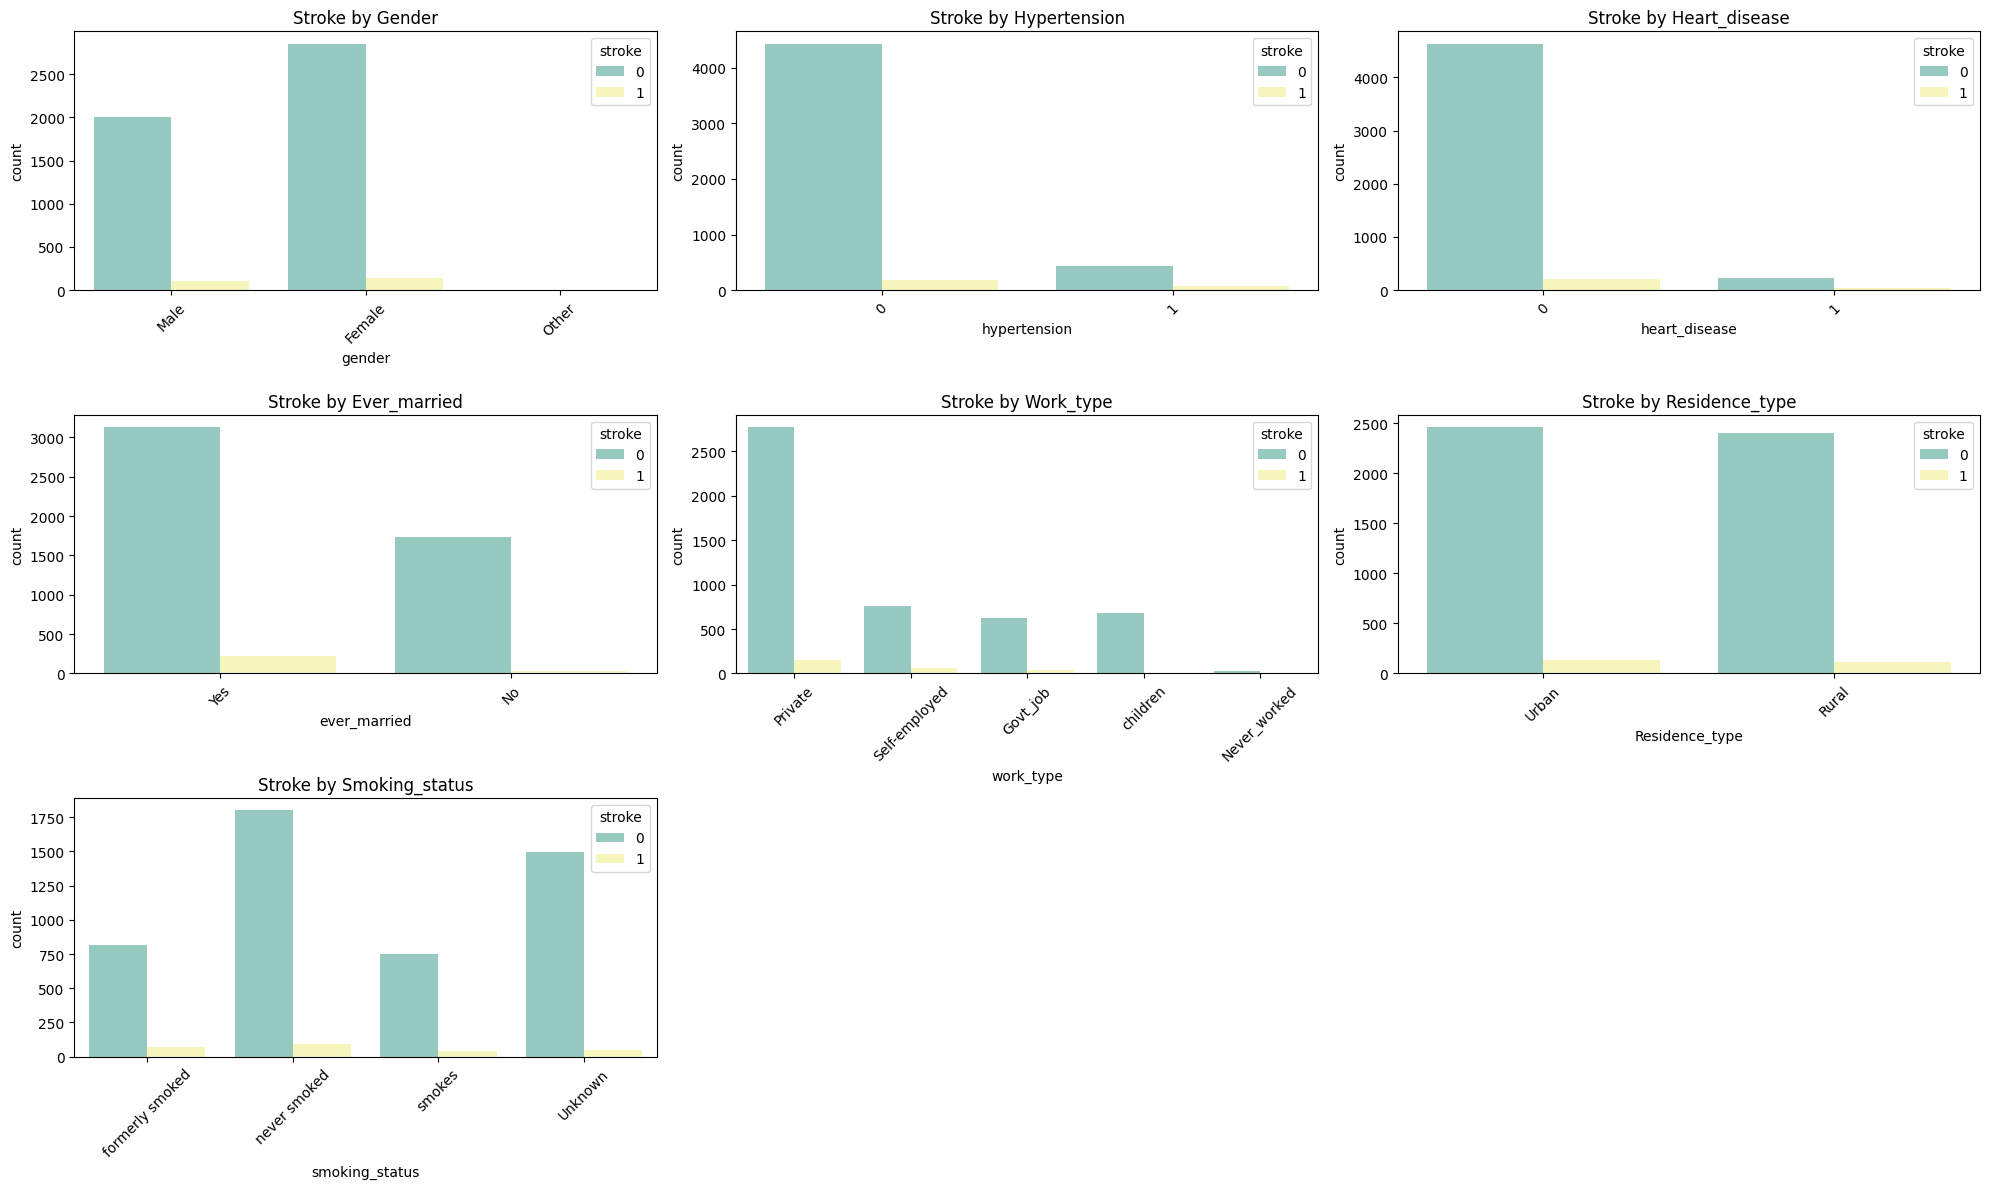

In [11]:
# Count plots for binary/categorical variables against the target variable 'stroke'
binary_categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

plt.figure(figsize=(20, 12))
for i, var in enumerate(binary_categorical_vars):
    plt.subplot(3, 3, i+1)
    sns.countplot(x=var, data=data, hue='stroke', palette="Set3")
    plt.title(f'Stroke by {var.capitalize()}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Let's also analyse one by one the impact of each variable on the target variable:
- **Gender:** Stroke incidence is shown in both male and female groups with a seemingly higher absolute number in females, likely due to the greater number of females in the dataset. The proportion within each gender would be crucial to examine to understand the risk fully.
- **Hypertension:** There's a visible difference in stroke incidence between patients with and without hypertension, with those having hypertension showing a higher incidence of stroke. This suggests hypertension is an important factor in stroke risk.
- **Heart Disease:** Patients with heart disease appear to have a higher incidence of stroke compared to those without. The presence of heart disease seems to be a significant risk factor for stroke.
- **Ever Married:** There's a noticeable number of stroke cases among those who have been married. While this may not be directly indicative of risk, it correlates with the fact that older adults are more likely to have been married and also at higher risk for stroke.
- **Work Type:** The incidence of stroke varies across work types, with 'Private' and 'Self-employed' categories showing a higher number of stroke cases. This could be related to stress levels, lifestyle factors, or simply reflect the larger numbers of people in these categories.
- **Residence Type:** There is a slight difference in stroke occurrence between rural and urban residents, with urban residents showing a slightly higher count of stroke cases. However, the difference is not as pronounced as with some other variables.
- **Smoking Status:** The distribution of stroke cases among different smoking statuses shows higher stroke incidence in the 'formerly smoked' and 'smokes' categories, which is consistent with the literature on smoking as a risk factor for stroke. The 'Unknown' category indicates missing data, which needs to be addressed.

**2.2.1:** Looking more into smoking-status variable:

In [12]:
smoking_status_counts = data['smoking_status'].value_counts(dropna=False)
print(smoking_status_counts)

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


From these resultn we can see that the 'Unknown' category constitutes a significant portion of the dataset. Given that nearly as many entries are labeled 'Unknown' as 'never smoked', which is the most frequent known category, outright deletion of these records could result in a substantial loss of data and potential bias.
We believe it is important to treat 'Unknown' as a Separate Category for several reasons:
- **Preserves Data Integrity:** Keeps all observations in the dataset, avoiding the loss of valuable information from a significant number of records.
- **Real-World Relevance:** Recognizes the common issue of incomplete medical records, providing insights into the impact of unknown patient data on stroke risk.
- **Simplicity in Analysis:** Offers a straightforward approach without introducing potential biases from imputation assumptions, making the analysis more transparent and easier to replicate.

### 2.3: Looking into the continuous variables:

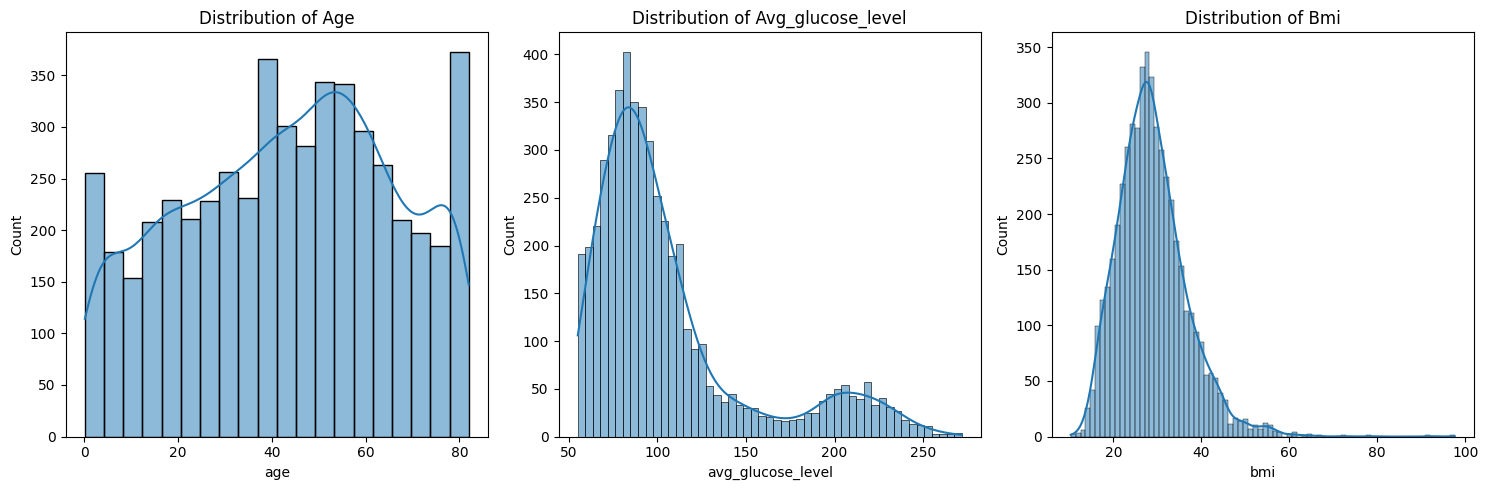

In [13]:
# Histograms for continuous variables
continuous_vars = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(15, 5))
for i, var in enumerate(continuous_vars):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[var], kde=True)
    plt.title(f'Distribution of {var.capitalize()}')

plt.tight_layout()
plt.show()

From the above graphs here are some insights and comments we can do.
- **Age**: The age distribution is fairly uniform, indicating that the dataset includes individuals across a wide range of ages. This is positive because it allows for analysis across the age spectrum and for understanding if age is a factor in stroke incidence. Since stroke risk typically increases with age, a balanced age distribution is essential to capture this trend without bias.
- **BMI (Body Mass Index)**: The BMI distribution appears to be roughly normal with a slight right skew. This skew suggests that there is a larger portion of the dataset with individuals having a BMI above the mean. The right-tail thickness could indicate a prevalence of overweight or obesity in the sample population, or it might reflect societal trends toward higher BMIs. The presence of this skew could be important when considering risk factors for stroke, as a higher BMI is often associated with increased health risks, including the likelihood of stroke.
- **Average Glucose Level**: The distribution of average glucose levels shows a right skew, with a secondary peak on the higher end. This indicates that while most individuals have glucose levels within a "normal" range, there is a significant number of individuals with elevated glucose levels. This secondary peak might represent a subgroup within the population, such as those with prediabetes or diabetes, which are conditions related to higher stroke risk.


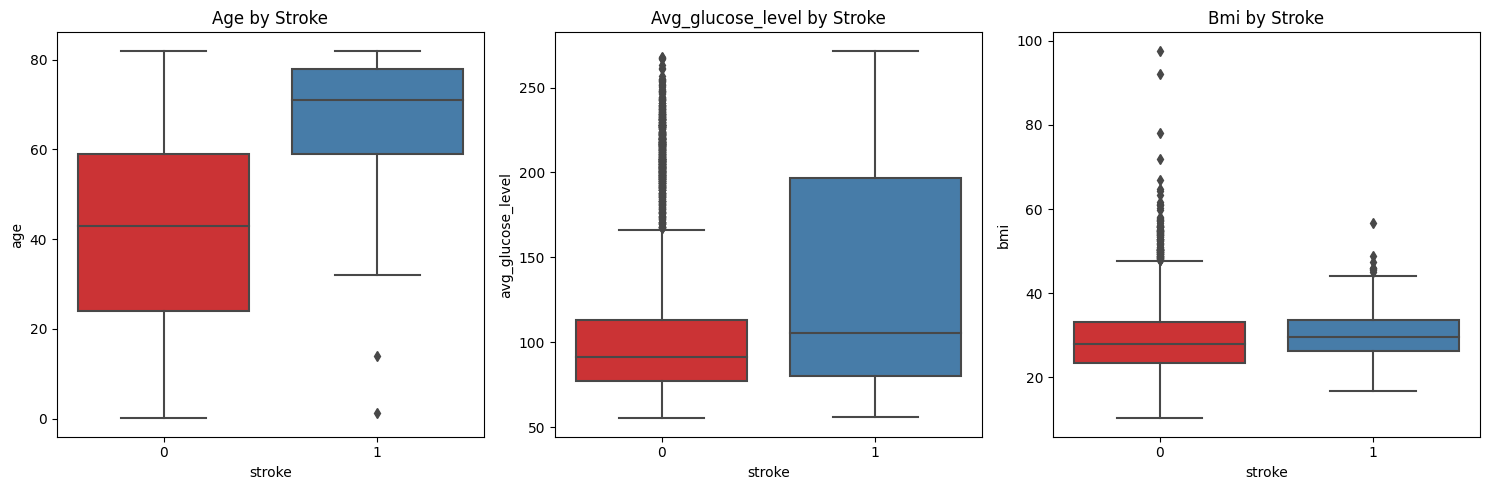

In [14]:
# Box plots for continuous variables against the target variable 'stroke'
plt.figure(figsize=(15, 5))
for i, var in enumerate(continuous_vars):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=var, x='stroke', data=data, palette="Set1")
    plt.title(f'{var.capitalize()} by Stroke')

plt.tight_layout()
plt.show()

From these box plots we can also do several observations:
- **Age by Stroke:** There's a clear difference in the age distributions when comparing those who have had a stroke to those who have not. The median age of stroke patients is higher, and the interquartile range is shifted towards an older age. This suggests that age is a significant risk factor for strokes, which aligns with medical understanding.
- **Average Glucose Level by Stroke:** Patients who have had a stroke tend to have higher median glucose levels, with a wider interquartile range. This aligns with the known risk factor of high blood glucose for strokes. The presence of outliers, particularly on the higher glucose levels, underscores the variability within the population and could point to individuals with unmanaged or undiagnosed diabetes.

These interpretations are consistent with medical knowledge that identifies older age and higher glucose levels as risk factors for stroke. The box plots suggest that these variables may be important features for predicting the likelihood of a stroke in machine learning models.


## 3.Exploratory Data Analysis:

### 3.1: Checking for null values

In [15]:
# Check for missing values
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

The null values for bmi, will be replaced with the mean of the column.

In [16]:
# Calculate the mean of the 'bmi' column
bmi_mean = data['bmi'].mean()

# Replace null values with the mean
data['bmi'].fillna(bmi_mean, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### 3.2 Correlation Matrix:

<ipython-input-17-e16311503026>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True)


<Axes: >

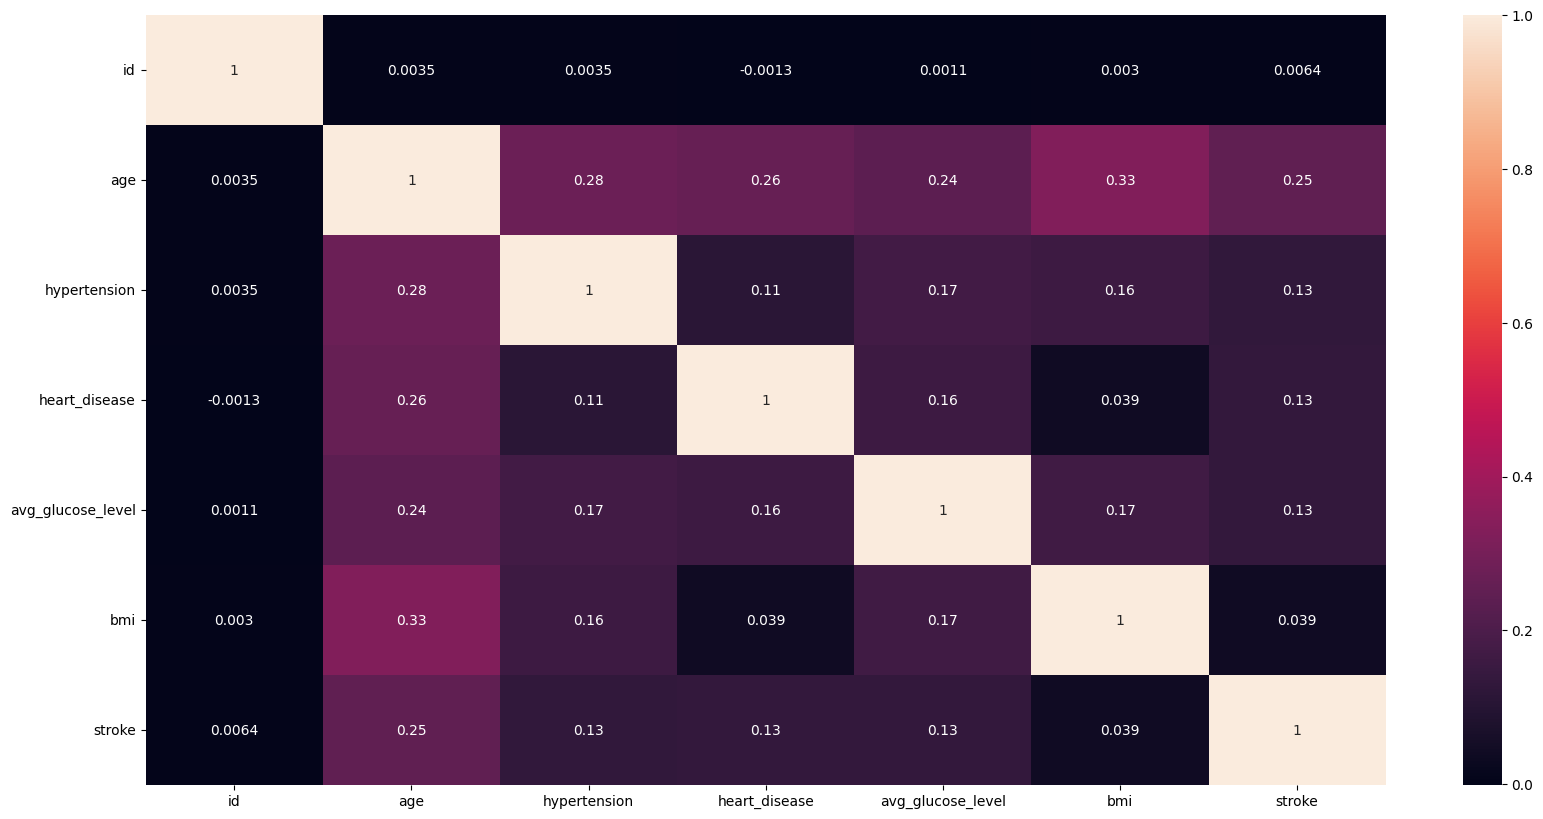

In [17]:
# Let's check the correlation between the variables
# Strong correlation between the mean radius and mean perimeter, mean area and mean primeter
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(), annot=True)

*Interpretation/Comment:*            
From this correlation matrix, we observe that there are no strong correlation that would indicate multicolinearity between our variables and therefore would require us to delete some of them. It is important to mention, that strong correlations are considered when the correlation us superior to |0.66|.    
We observe that the *bmi* variable has a very low correlation with the target variable (0.039) which confirms the intuition from the data visualization part, that this features does not explain very well the target variable (stroke). Therefore we will not take this fetaure into account when doing our model.      
Also we note that another variable that has a very low correlation with our target variable (*stroke*) is the id which is an identifier and will be dropped.

### 3.3: Data Cleaning:
We will drop the variables we believe not important.

In [18]:
data = data.drop(['id', 'bmi'], axis=1)

## 4. Train/Test Split:

### 4.1: Training and Testing split:

In [19]:
# Split data into features (X) and target (y)
X = data.drop('stroke', axis=1)
y = data['stroke']

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4088 entries, 802 to 860
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4088 non-null   object 
 1   age                4088 non-null   float64
 2   hypertension       4088 non-null   int64  
 3   heart_disease      4088 non-null   int64  
 4   ever_married       4088 non-null   object 
 5   work_type          4088 non-null   object 
 6   Residence_type     4088 non-null   object 
 7   avg_glucose_level  4088 non-null   float64
 8   smoking_status     4088 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 319.4+ KB


### 4.2: One-Hot-Encoding Categorical Variables:

In [22]:
# Define the categorical columns
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Define numerical columns
numerical_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level']

In [23]:
# Create a ColumnTransformer which will apply OneHotEncoder to the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'  # This will pass through other columns without transforming
)

In [24]:
# Fit & Transform the ColumnTransformer to the training data
X_train_transformed = preprocessor.fit_transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
# Get the one-hot encoded column names
ohe_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Concatenate with the numerical column names
all_column_names = np.concatenate((ohe_columns, numerical_columns), axis=0)

# Convert the numpy array returned by ColumnTransformer into a DataFrame
X_train_transformed_df= pd.DataFrame(X_train_transformed, columns=all_column_names)

In [26]:
X_train_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4088 entries, 0 to 4087
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender_Female                   4088 non-null   float64
 1   gender_Male                     4088 non-null   float64
 2   ever_married_No                 4088 non-null   float64
 3   ever_married_Yes                4088 non-null   float64
 4   work_type_Govt_job              4088 non-null   float64
 5   work_type_Never_worked          4088 non-null   float64
 6   work_type_Private               4088 non-null   float64
 7   work_type_Self-employed         4088 non-null   float64
 8   work_type_children              4088 non-null   float64
 9   Residence_type_Rural            4088 non-null   float64
 10  Residence_type_Urban            4088 non-null   float64
 11  smoking_status_Unknown          4088 non-null   float64
 12  smoking_status_formerly smoked  40

### 4.3: Balancing the training dataset:  
    
Since the minority dataset is very small, we need to use a technique to balance out the dataset. We belive that using SMOTE techhnique is the best for several reasons:
- Class Imbalance Correction: SMOTE helps to mitigate the class imbalance by generating synthetic samples for the minority class, leading to a more balanced dataset. This is particularly important in medical datasets like here, where the event of interest (stroke) is rare compared to non-events.
- Model Generalization: By creating synthetic samples, SMOTE enables the model to learn more generalized patterns rather than simply memorizing the minority class instances. This can improve model performance on unseen data.
- Overfitting Reduction: Unlike simple upsampling, which can cause overfitting by repeating minority class samples, SMOTE generates new, synthetic samples through interpolation, which helps in preventing the model from overfitting to the replicated samples.
- Algorithmic Harmony: SMOTE works well with many machine learning algorithms, especially those that are sensitive to the distribution of the target variable, like RandomForest, which is being used in this case. It provides a diverse set of examples for the algorithm to learn from.
- Improved Metrics: For imbalanced datasets, metrics like precision, recall, and F1-score are more informative than accuracy. SMOTE tends to improve these metrics for the minority class by providing a more balanced view of the class distribution, which is crucial for stroke prediction where the cost of false negatives is high.

In [27]:
# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Fit the model and resample the data
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

In [28]:
X_train_smote.shape

(7802, 19)

In [29]:
y_train_smote.shape

(7802,)

## 5. Creation of the Model:

Creating a Random Forest Model with Hyperparameter tuning:

In [30]:
# Define the Random Forest model with BayesSearchCV for hyperparameter tuning
rf_model = RandomForestClassifier(random_state=42)

param_space = {
    'n_estimators': (10, 1000),
    'max_depth': (1, 32),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}
opt = BayesSearchCV(
    rf_model,
    param_space,
    n_iter=32,
    cv=5,
    n_jobs=-1)

opt.fit(X_train_smote, y_train_smote)

BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
              n_iter=32, n_jobs=-1,
              search_spaces={'max_depth': (1, 32), 'min_samples_leaf': (1, 10),
                             'min_samples_split': (2, 10),
                             'n_estimators': (10, 1000)})

In [31]:
# Return the parameters of the best model
opt.best_params_

OrderedDict([('max_depth', 27),
             ('min_samples_leaf', 1),
             ('min_samples_split', 6),
             ('n_estimators', 35)])

In [32]:
# Make 'clf' an instance of the best model.
clf = opt.best_estimator_
clf

RandomForestClassifier(max_depth=27, min_samples_split=6, n_estimators=35,
                       random_state=42)

In [33]:
# Display the score obtained by the best model.
opt.best_score_

0.9728362818048918

## 6. Make Predictions on the test dataset:

We do not balance the test dataset as it has to forecast reality!

### 6.1: One-Hot-Encoding the test set:

In [34]:
# Transform the test data using the fitted preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Get the one-hot encoded column names for categorical columns from the preprocessor
ohe_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Concatenate with the numerical column names
all_column_names = np.concatenate((ohe_columns, numerical_columns), axis=0)

# Convert the numpy array returned by ColumnTransformer into a DataFrame
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_column_names)
X_test_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender_Female                   1022 non-null   float64
 1   gender_Male                     1022 non-null   float64
 2   ever_married_No                 1022 non-null   float64
 3   ever_married_Yes                1022 non-null   float64
 4   work_type_Govt_job              1022 non-null   float64
 5   work_type_Never_worked          1022 non-null   float64
 6   work_type_Private               1022 non-null   float64
 7   work_type_Self-employed         1022 non-null   float64
 8   work_type_children              1022 non-null   float64
 9   Residence_type_Rural            1022 non-null   float64
 10  Residence_type_Urban            1022 non-null   float64
 11  smoking_status_Unknown          1022 non-null   float64
 12  smoking_status_formerly smoked  10

### 6.2: Doing predictions:

In [35]:
# Predict the classes of the samples in the test dataset using the best model.
y_test_pred = clf.predict(X_test_transformed_df)
y_test_pred.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


(1022,)

## 7. Construct the confusion matrix and print the classification report:

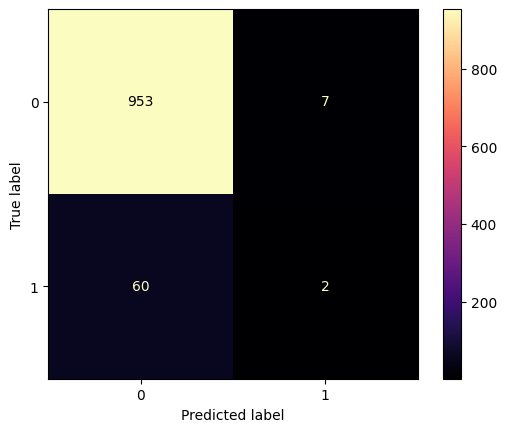

In [36]:
# Removing the seaborn visualization removes the white lines that come with it.
sns.reset_orig()

# Create a confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    labels = clf.classes_,
    cmap = 'magma'
);

If we read this confusion matrix, it means that:
- True negatives (TN) - (0,0): The model correctly predicted 954 non-stroke cases.
- False positives (FP) - (0,1): There were 6 instances where the model incorrectly predicted a stroke.
- False negatives (FN) - (1,0): The model incorrectly predicted 60 non-stroke cases where the patients actually did have a stroke.
- True positives (TP) - (1,1): The model correctly predicted 2 stroke cases.

In [37]:
# Print the classification report with two target names
print(classification_report(y_test, y_test_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       960
           1       0.22      0.03      0.06        62

    accuracy                           0.93      1022
   macro avg       0.58      0.51      0.51      1022
weighted avg       0.90      0.93      0.91      1022



When looking into the Classification Report we can do the following observations:
- For the non-stroke predictions (class '0'):
  - Precision is high (0.94), indicating that when the model predicts a non-stroke, it is correct 94% of the time.
  - Recall is also high (0.99), meaning the model captures 99% of all actual non-stroke cases.
  - The F1-score (0.97) is also high, showing a good balance between precision and recall for the non-stroke class.
- For the stroke predictions (class '1'):
  - Precision is low (0.22), meaning that only 22% of stroke predictions were actually correct.
  - Recall is very low (0.03), indicating the model only correctly identified 3% of all actual stroke cases.
  - The F1-score (0.06) for the stroke class is poor, reflecting the imbalance between precision and recall.
- The accuracy (0.93) of the model is high, but this metric is misleading due to the imbalanced nature of the dataset. Most of the data belongs to the non-stroke class and this is an important problem that can not be faced only by balancing out the dataset.
- The macro average F1-score (0.51) shows an average performance across both classes that is not weighted by the class imbalance, indicating that the model's performance on the minority class (stroke cases) is not as satisfactory as one would expect.
- The weighted average F1-score (0.91) takes the class imbalance into account and is therefore skewed by the model's good performance on the majority class.

In conclusion, while the model performs well in identifying non-stroke cases (class '0'), it struggles more with stroke cases (class '1'), which are of more clinical importance. The low recall for stroke cases suggests that the model would miss an important portion of actual stroke events. Therefore, despite the overall accuracy, the model needs improvement in detecting the minority class—stroke cases. In order to improve the model it is fundamental to further increase the dataset with cases realted to 'stroke'.





## 8. Save and export model:

In [38]:
# Save the mode
filename = 'rf_model.sav'
pickle.dump(opt,open(filename,'wb'))

In [40]:
# Save the preprocessor
preprocessor.fit(X_train)
dump(preprocessor, 'preprocessing.joblib')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['preprocessing.joblib']